In [1]:
%pylab inline
import sklearn
import sklearn.mixture
from scipy import signal

Populating the interactive namespace from numpy and matplotlib


['09', '10', '11', '12', '13', '14', '15']


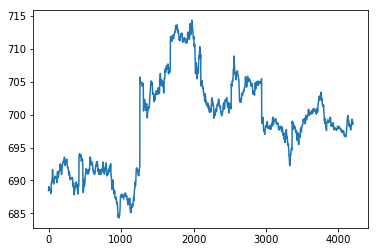

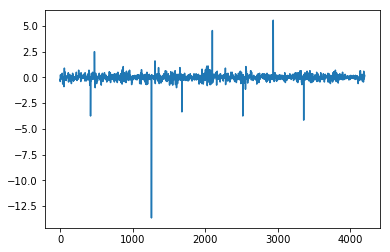

In [2]:
L = []
Good = map(str, range(9,16)) # od 9 do 15
Good[0] = '09'
print Good
for ff in open('OrderBookSnapshots.csv'):
    pre, tail = ff.split('BID')
    if pre.split()[1][:2] not in Good:
        continue
    mid, post = tail.split('ASK')
    mid = map(float, mid.split())
    mid = array(zip(mid[::2], mid[1::2]))
    post = map(float, post.split())
    post = array(zip(post[::2], post[1::2]))
    L.append((mid,post))
L = array(L) # czyste dane
P = array(map(lambda x : (x[0].max(axis=0)[0]+x[1].min(axis=0)[0])/2,L)) # P to lista cen
P = signal.medfilt(P,kernel_size=5)
plot(P)
dif = (P[:-1]-P[1:])
dif = dif.reshape(-1,1) # różnice cen
show()
plot(dif)

In [12]:
def X1(D):
    return array(([D[0][-2], D[0][-1],D[1][0], D[1][1]])).reshape((8))

X1 = array(map(X1,L[:-1]))
n,d = X1.shape
A1 = zeros((n,3))

A1[(dif>0.5).reshape(n), 0] = 1
A1[((dif<=0.5)*(dif>=-0.5)).reshape(n), 1] = 1
A1[(dif<-0.5).reshape(n), 2] = 1

save('X1', X1)
save('A1', A)

In [3]:
# Generują listy A

def WzrostWKolejnych(IK = 5, p = 0.05): # sprawdzamy, czy kiedykolwiek w IK momentach po danym cena będzie wyższa niż teraz. Współczynnik p określa jaką frakcję największych zman bierzemy pod uwagę.
    MXf = []
    for i in range(len(P)):
        MXf.append(P[i])
        for j in range(min(len(P)-i, IK)):
            MXf[-1] = max(MXf[-1], P[i+j])
    difff = (MXf-P)
    div = sorted(difff)[int(len(difff)*(1-p))]
    
    A = zeros((len(difff),2))
    A[difff >= div, 1] = 1
    A[difff < div, 0] = 1
    print A.sum(), A[:, 0].sum(), A[:, 1].sum()
    return A

def SpadekWKolejnych(IK = 5, p = 0.05): # sprawdzamy, czy kiedykolwiek w IK momentach po danym cena będzie niższa niż teraz. Współczynnik p określa jaką frakcję największych zman bierzemy pod uwagę.
    MNf = []
    for i in range(len(P)):
        MNf.append(P[i])
        for j in range(min(len(P)-i, IK)):
            MNf[-1] = min(MNf[-1], P[i+j])
    difff = (MNf-P)
    div = sorted(difff)[int(len(difff)*(p))]
    
    A = zeros((len(difff),2))
    A[difff <= div, 1] = 1
    A[difff > div, 0] = 1
    return A

def SkokWKolejnych(IK = 5, p = 0.05):
    MXf = []
    MNf = []
    for i in range(len(P)):
        MXf.append(P[i])
        MNf.append(P[i])
        for j in range(min(len(P)-i, IK)):
            MNf[-1] = min(MNf[-1], P[i+j])
            MXf[-1] = max(MXf[-1], P[i+j])
    difff = stack((MXf-P,P-MNf)).max(axis=0)
    div = sorted(difff)[int(len(difff)*(1-p))]
    A = zeros((len(difff),2))
    A[difff >= div, 1] = 1
    A[difff < div, 0] = 1
    return A

In [4]:
# generują listy X

def LtoV():
    najm = 10000
    najw = 0
    RL = []
    for l,p in zip(L,P):
        ST = zeros(500)
        for a,b in l[0]:
            najm = min(najm, a-p)
            najw = max(najw, a-p)
            ST[int(round(a-p))+250] = -b
        for a,b in l[1]:
            najm = min(najm, a-p)
            najw = max(najw, a-p)
            ST[int(round(a-p))+250] = b
        RL.append(ST)
    print najm,najw
    return array(RL)

V = LtoV()


-202.55 215.7


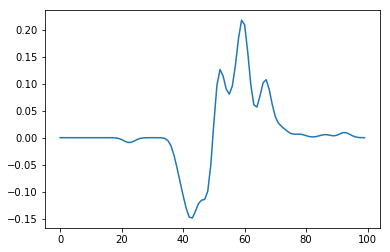

In [7]:
def getS(mi, sig = 15):
    S = signal.gaussian(1000, sig, sym=True)
    return S[500-mi:1000-mi]

def GausMul(dist = 5, sig = 9):
    res = []
    for v in V:
        nv = []
        for i in range(0,500,dist):
            nv.append((v*getS(i,sig)).sum()/(abs(v).sum()))
        res.append(nv)
    return array(res)
GM = GausMul()
plot(GM[0])

In [5]:
def umb(ile = 10):
    R = []
    for v,p in zip(V,P):
        res = zeros(2 +2*ile)
        cap = abs(v).sum()
        res[0] = -v[v < 0].sum()/cap
        res[1] = v[v>0].sum()/cap
        
        
        
        j = 250
        while v[j] < 0: j+=1
        while v[j-1] > 0: j -= 1
        capG = v[v>0].sum()
        capD = v[v<0].sum()
        CS = 0
        for i in range(ile):
            while CS < (i+1)*(1.0/ile)*capG:
                CS += v[j]
                j+=1
            res[2+ile+i] = (j-250+p)/p
        
        j = 250
        while v[j] < 0: j+=1
        while v[j-1] > 0: j-=1
        CS = 0
        for i in range(ile):
            while CS > (i+1)*(1.0/ile)*capD:
                CS += v[j-1]
                j -= 1
            res[ile+1-i] = (j-250+p)/p
        
        R.append(res)
    return array(R)
umb(20).shape

(4200L, 42L)

In [8]:
#dowolna kombinacja jest dobra

for Agen in [WzrostWKolejnych, SpadekWKolejnych, SkokWKolejnych]:
    A = Agen()
    for Xgen in [GausMul, umb]:
        X = Xgen()

4200.0 3988.0 212.0
